[View in Colaboratory](https://colab.research.google.com/github/jagatfx/turicreate-colab/blob/master/turicreate_image_similarity.ipynb)

# Image similarity
https://apple.github.io/turicreate/docs/userguide/image_similarity/

Given an image, the goal of an image similarity model is to find "similar" images. Just like in image classification, deep learning methods have been shown to give incredible results on this challenging problem. However, unlike in image similarity, there isn't a need to generate labeled images for model creation. This model is completely unsupervised.

## Turi Create and GPU Setup

In [0]:
!apt install libnvrtc8.0
!pip uninstall -y mxnet-cu80 && pip install mxnet-cu80==1.1.0
!pip install turicreate

## Google Drive Access

You will be asked to click a link to generate a secret key to access your Google Drive. 

Copy and paste secret key it into the space provided with the notebook.

In [1]:
import os.path
from google.colab import drive

# mount Google Drive to /content/drive/My Drive/
if os.path.isdir("/content/drive/My Drive"):
  print("Google Drive already mounted")
else:
  drive.mount('/content/drive')

Google Drive already mounted


## Fetch Data

Use the Caltech-101 dataset which contains images objects belonging to 101 categories with about 40 to 800 images per category 
*   L. Fei-Fei, R. Fergus and P. Perona. One-Shot learning of object categories. IEEE Trans. Pattern Recognition and Machine Intelligence. https://authors.library.caltech.edu/5407/1/LIFieeetpam06.pdf

In [0]:
import os.path
import urllib.request
import tarfile
import zipfile
import gzip
from shutil import copy

def fetch_remote_datafile(filename, remote_url):
  if os.path.isfile("./" + filename):
    print("already have " + filename + " in workspace")
    return
  print("fetching " + filename + " from " + remote_url + "...")
  urllib.request.urlretrieve(remote_url, "./" + filename)

def cache_datafile_in_drive(filename):
  if os.path.isfile("./" + filename) == False:
    print("cannot cache " + filename + ", it is not in workspace")
    return
  
  data_drive_path = "/content/drive/My Drive/Colab Notebooks/data/"
  if os.path.isfile(data_drive_path + filename):
    print("" + filename + " has already been stored in Google Drive")
  else:
    print("copying " + filename + " to " + data_drive_path)
    copy("./" + filename, data_drive_path)
  

def load_datafile_from_drive(filename, remote_url=None):
  data_drive_path = "/content/drive/My Drive/Colab Notebooks/data/"
  if os.path.isfile("./" + filename):
    print("already have " + filename + " in workspace")
  elif os.path.isfile(data_drive_path + filename):
    print("have " + filename + " in Google Drive, copying to workspace...")
    copy(data_drive_path + filename, ".")
  elif remote_url != None:
    fetch_remote_datafile(filename, remote_url)
  else:
    print("error: you need to manually download " + filename + " and put in drive")
    
def extract_datafile(filename, expected_extract_artifact=None):
  if expected_extract_artifact != None and (os.path.isfile(expected_extract_artifact) or os.path.isdir(expected_extract_artifact)):
    print("files in " + filename + " have already been extracted")
  elif os.path.isfile("./" + filename) == False:
    print("error: cannot extract " + filename + ", it is not in the workspace")
  else:
    extension = filename.split('.')[-1]
    if extension == "zip":
      print("extracting " + filename + "...")
      data_file = open(filename, "rb")
      z = zipfile.ZipFile(data_file)
      for name in z.namelist():
          print("    extracting file", name)
          z.extract(name, "./")
      data_file.close()
    elif extension == "gz":
      print("extracting " + filename + "...")
      if filename.split('.')[-2] == "tar":
        tar = tarfile.open(filename)
        tar.extractall()
        tar.close()
      else:
        data_zip_file = gzip.GzipFile(filename, 'rb')
        data = data_zip_file.read()
        data_zip_file.close()
        extracted_file = open('.'.join(filename.split('.')[0:-1]), 'wb')
        extracted_file.write(data)
        extracted_file.close()
    elif extension == "tar":
      print("extracting " + filename + "...")
      tar = tarfile.open(filename)
      tar.extractall()
      tar.close()
    elif extension == "csv":
      print("do not need to extract csv")
    else:
      print("cannot extract " + filename)
      
def load_cache_extract_datafile(filename, expected_extract_artifact=None, remote_url=None):
  load_datafile_from_drive(filename, remote_url)
  extract_datafile(filename, expected_extract_artifact)
  cache_datafile_in_drive(filename)
  

In [6]:
load_cache_extract_datafile("101_ObjectCategories.tar.gz", "101_ObjectCategories", "http://www.vision.caltech.edu/Image_Datasets/Caltech101/101_ObjectCategories.tar.gz")

already have 101_ObjectCategories.tar.gz in workspace
files in 101_ObjectCategories.tar.gz have already been extracted
101_ObjectCategories.tar.gz has already been stored in Google Drive


## Setup Turi Create

In [0]:
import mxnet as mx
import turicreate as tc

In [0]:
# Use all GPUs (default)
tc.config.set_num_gpus(-1)

# Use only 1 GPU
#tc.config.set_num_gpus(1)

# Use CPU
#tc.config.set_num_gpus(0)

## Loading Data

Load images in SFrame

In [0]:
# Load images from the downloaded data
reference_data  = tc.image_analysis.load_images('./101_ObjectCategories')
reference_data = reference_data.add_row_number()

In [0]:
# From the path-name, create a label column
reference_data['label'] = reference_data['path'].apply(lambda path: path.split('/')[2])

In [12]:
reference_data.groupby('label', [tc.aggregate.COUNT]).sort("Count", ascending = False)

label,Count
airplanes,800
Motorbikes,798
BACKGROUND_Google,467
Faces_easy,435
Faces,435
watch,239
Leopards,200
bonsai,128
car_side,123
ketch,114


In [0]:
# Save the SFrame for future use
reference_data.save('./caltech-101.sframe')

In [8]:
reference_data.head()

id,path,image
0,./101_ObjectCategories/BACKGROUND_Google/image ...,Height: 144 Width: 145
1,./101_ObjectCategories/BACKGROUND_Google/image ...,Height: 817 Width: 656
2,./101_ObjectCategories/BACKGROUND_Google/image ...,Height: 144 Width: 144
3,./101_ObjectCategories/BACKGROUND_Google/image ...,Height: 200 Width: 200
4,./101_ObjectCategories/BACKGROUND_Google/image ...,Height: 199 Width: 180
5,./101_ObjectCategories/BACKGROUND_Google/image ...,Height: 889 Width: 700
6,./101_ObjectCategories/BACKGROUND_Google/image ...,Height: 176 Width: 150
7,./101_ObjectCategories/BACKGROUND_Google/image ...,Height: 382 Width: 439
8,./101_ObjectCategories/BACKGROUND_Google/image ...,Height: 296 Width: 500
9,./101_ObjectCategories/BACKGROUND_Google/image ...,Height: 500 Width: 500


In [0]:
from IPython.display import display
from IPython.display import HTML
from PIL import Image
from io import BytesIO
import glob
import random
import base64
import pandas as pd

def get_thumbnail(path):
  i = Image.open(path)
  i.thumbnail((150, 150), Image.LANCZOS)
  return i
  
def get_thumbnail_from_image(img):
  i = img.copy()
  i.thumbnail((150, 150), Image.LANCZOS)
  return i

def image_base64(im):
  if isinstance(im, str):
    im = get_thumbnail(im)
  with BytesIO() as buffer:
    im.save(buffer, 'jpeg')
    return base64.b64encode(buffer.getvalue()).decode()

def image_formatter(im):
  return f'<img style="display:inline;margin:1px" src="data:image/jpeg;base64,{image_base64(im)}">'
  
def preview_images(reference_data, num_previews=30):
  images = list(map(lambda x:image_formatter(get_thumbnail(x)), reference_data[0:num_previews]['path']))
  display(HTML(''.join(images)))


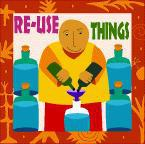
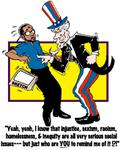
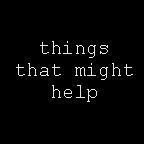
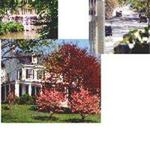
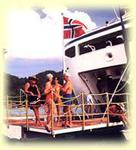
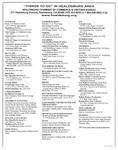
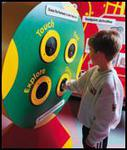
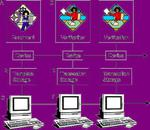
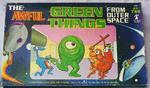
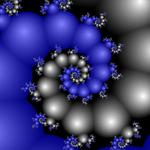

In [11]:
preview_images(reference_data, 10)


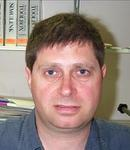
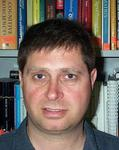
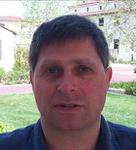
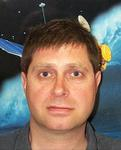
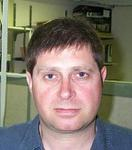
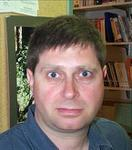
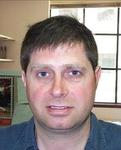
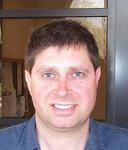
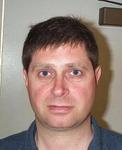
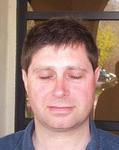
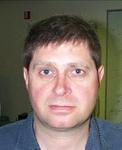
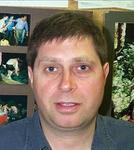
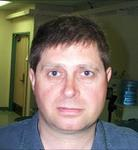
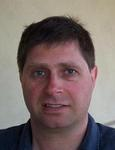
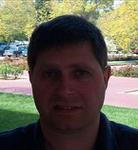
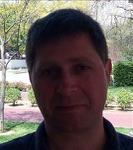
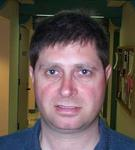
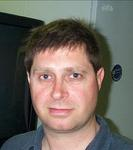
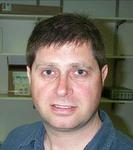
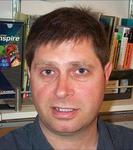
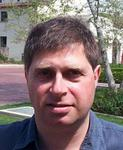
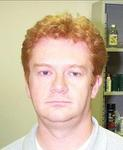
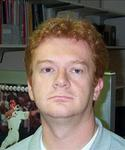
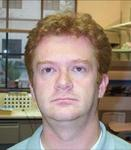
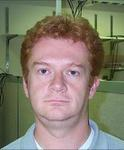
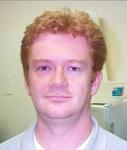
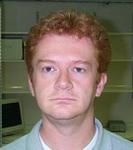
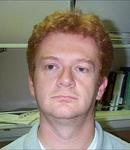
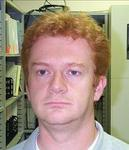
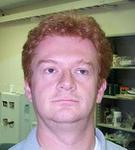

In [18]:
preview_images(reference_data[reference_data["label"]=="Faces_easy"])

## Creating the model

*  Stage 1: Uses a pre-trained CNN classifier on a large, general dataset. A good example is ImageNet, with 1000 categories and 1.2 million images.
*   Stage 2: The outputs of each layer in the CNN can be viewed as a meaningful vector representation of each image. Extract these feature vectors from the layer prior to the output layer on each image of your task.
* Stage 3: Create a nearest neighbors model with those feature vectors as input


In [0]:
# Use all GPUs (default)
tc.config.set_num_gpus(-1)

# Use only 1 GPU
#tc.config.set_num_gpus(1)

# Use CPU
#tc.config.set_num_gpus(0)

In [13]:
# create an image similarity model using the data
model = tc.image_similarity.create(reference_data)

Performing feature extraction on resized images...
Completed   64/9144
Completed  128/9144
Completed  192/9144
Completed  256/9144
Completed  320/9144
Completed  384/9144
Completed  448/9144
Completed  512/9144
Completed  576/9144
Completed  640/9144
Completed  704/9144
Completed  768/9144
Completed  832/9144
Completed  896/9144
Completed  960/9144
Completed 1024/9144
Completed 1088/9144
Completed 1152/9144
Completed 1216/9144
Completed 1280/9144
Completed 1344/9144
Completed 1408/9144
Completed 1472/9144
Completed 1536/9144
Completed 1600/9144
Completed 1664/9144
Completed 1728/9144
Completed 1792/9144
Completed 1856/9144
Completed 1920/9144
Completed 1984/9144
Completed 2048/9144
Completed 2112/9144
Completed 2176/9144
Completed 2240/9144
Completed 2304/9144
Completed 2368/9144
Completed 2432/9144
Completed 2496/9144
Completed 2560/9144
Completed 2624/9144
Completed 2688/9144
Completed 2752/9144
Completed 2816/9144
Completed 2880/9144
Completed 2944/9144
Completed 3008/9144
Completed

Starting brute force nearest neighbors model training.

## Querying the model
Once created, we can query the model to retrieve the k closest images in the original reference data (by setting the k parameter). The result of the query method is an SFrame with four columns: query label, reference label, distance, and rank of the reference point among the query point's nearest neighbors.

Note: You can pass in an image, or an SArray of images into the model.query method. This image or array of images does not need to be a part of the original dataset.

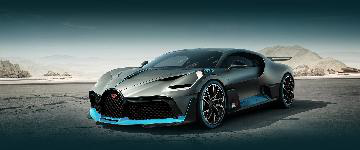

In [66]:
image_url = "https://assets.bugatti.com/fileadmin/_processed_/sei/p2/se-image-68892c07efdcf8d84f8f5398fbc2bfc3.jpg"
# image_url = "http://www.nyapplecountry.com/images/varities/redrome_300.jpg"
sample_image = tc.Image(image_url)
sample_image_thumb = tc.image_analysis.resize(sample_image, 360, 150)
sample_image_thumb.save("sample_image_thumb.jpg")
sample_image_thumb_pil = Image.open("sample_image_thumb.jpg")
display(sample_image_thumb_pil)

In [59]:
# query_results = model.query(reference_data[sample_index:sample_index+1], k=20)
query_results = model.query(sample_image, k=20)
query_results.head()

Performing feature extraction on resized images...
Completed 1/1


Starting pairwise querying.

+--------------+---------+-------------+--------------+

| Query points | # Pairs | % Complete. | Elapsed Time |

+--------------+---------+-------------+--------------+

| 0            | 1       | 0.0109361   | 31.554ms     |

| Done         |         | 100         | 368.688ms    |

+--------------+---------+-------------+--------------+

query_label,reference_label,distance,rank
0,236,14.4636887523434,1
0,4058,15.38857938379883,2
0,4075,15.98757250480625,3
0,4029,16.123324419084778,4
0,4092,16.225758105684292,5
0,4074,16.27985112895011,6
0,4012,16.322510735526574,7
0,4008,16.59311374784939,8
0,4028,16.681874027787096,9
0,4022,16.705088078802554,10



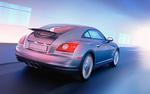
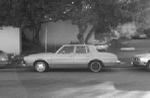
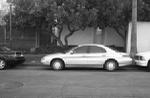
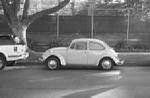
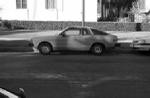
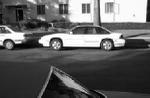
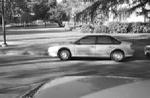
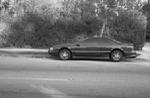
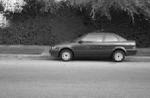
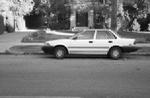
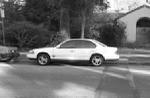
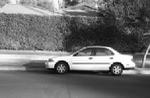
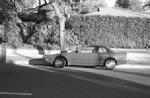
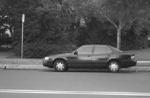
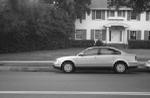
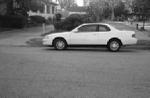
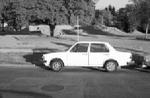
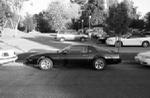
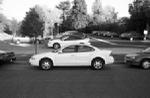
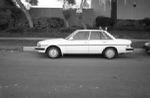

In [60]:
# get k most "similar" looking images
similar_rows = query_results[query_results['query_label'] == 0]['reference_label']
similar_rows_data = reference_data.filter_by(similar_rows, 'id')
preview_images(similar_rows_data)

## Similarity graph
In some cases, we want to find the most similar images in the reference dataset for all images in the reference dataset. The similarity_graph method returns an SGraph whose vertices are the row numbers of the reference dataset and whose edges indicate a nearest neighbor match. Specifically, the destination vertex of an edge is a nearest neighbor of the source vertex. similarity_graph can also return results in the same form as the query method if so desired.

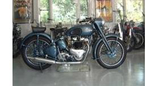

In [62]:
# sample an image from the reference_data
sample_index = 1900
sample_image_path = reference_data[sample_index]['path']
sample_image = Image.open(sample_image_path)
display(get_thumbnail(sample_image_path))

In [63]:
similarity_graph = model.similarity_graph(k=20)
similar_images = similarity_graph.edges

Starting blockwise similarity graph construction.

max rows per data block: 6207

number of reference data blocks: 2

+---------+-------------+--------------+

| # Pairs | % Complete. | Elapsed Time |

+---------+-------------+--------------+

| 4.2e+07 | 66.6667     | 10.92s       |

| 4.2e+07 | 66.6667     | 19.18s       |

| 6.3e+07 | 100         | 26.99s       |

| 6.3e+07 | 100         | 26.99s       |

+---------+-------------+--------------+

In [64]:
sample_similar_images = similar_images[similar_images["__src_id"]==sample_index].sort('rank')
sample_similar_images

__src_id,__dst_id,distance,rank
1900,1622,12.371572783554551,1
1900,1748,12.443521463595406,2
1900,2316,12.468552860746025,3
1900,2191,12.492627680126182,4
1900,1835,12.500266898149924,5
1900,1657,12.530727344320013,6
1900,1669,12.677752744635947,7
1900,2282,12.682952195422654,8
1900,1624,12.736271601805544,9
1900,2224,12.969721898942028,10



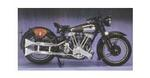
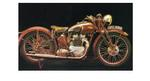
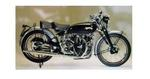
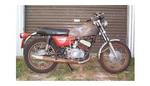
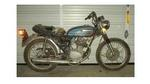
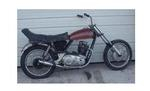
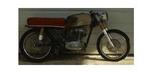
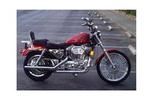
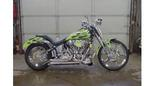
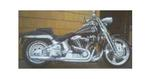
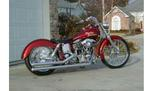
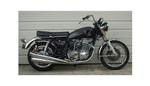
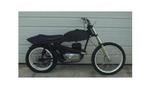
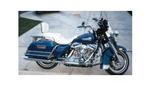
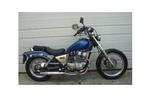
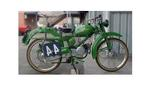
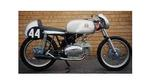
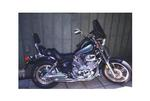
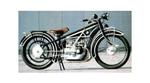
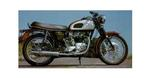

In [65]:
dst_ids = sample_similar_images["__dst_id"][0:20]
ref_similar_images = reference_data.filter_by(dst_ids, 'id')
preview_images(ref_similar_images)

## Save and Export Model

In [0]:
# saving the model
model.save('./image_similarity.model')
loaded_model = tc.load_model('./image_similarity.model')

In [27]:
# export model for CoreML
model.export_coreml("ImageSimilarity.mlmodel")

/usr/local/lib/python3.6/dist-packages/coremltools/_deps/__init__.py:118: DeprecationWarning: The 'warn' function is deprecated, use 'warning' instead
  % (tensorflow.__version__, TF_MAX_VERSION))


In [0]:
# download mlmodel locally
from google.colab import files
files.download("ImageSimilarity.mlmodel")

In [68]:
HTML('<iframe src="https://drive.google.com/file/d/1TateJAcNwL2UL5woxE60bTOvb0Y5ML35/preview" width="640" height="480"></iframe>')

In [0]:
# copy model to Google Drive
from shutil import copy
copy("/content/ImageSimilarity.mlmodel", "/content/drive/My Drive/Colab Notebooks/data/models/ImageSimilarity.mlmodel")

In [0]:
# copy model to Google Drive
from shutil import copytree
copytree("/content/ImageSimilarity.model", "/content/drive/My Drive/Colab Notebooks/data/models/ImageSimilarity.model")

See https://apple.github.io/turicreate/docs/userguide/image_similarity/export-coreml.html for details on CoreML deployment in Swift building off Apple example app https://developer.apple.com/documentation/vision/classifying_images_with_vision_and_core_ml